# Multi‑Armed Bandits (MAB)

### Where bandits fit in Reinforcement Learning (RL)
**Reinforcement Learning** (RL) studies how an agent should act in an environment to maximize long‑term reward. For example, what is the best policy to use in order to win a chess game. In full RL, there are states, actions, transition dynamics, and delayed consequences of actions.

**Bandits**, or more commonly, Multi‑Armed Bandits (MAB) are the minimal RL setting: effectively a single state (no dynamics), immediate rewards, and no state transitions. Bandits isolate the core tension of RL—**exploration vs. exploitation**—without modeling dynamics.

### Common applications
- **A/B/n testing and adaptive experiments** (web UX, ads)
- **Recommendations and ranking** (news feeds, products)
- **Clinical trials and operations** (adaptive allocation)
- **Hyperparameter tuning / algorithm selection**


### MAB setup

- **Setting**: There are $K$ independent actions ("arms"). Pulling arm $a$ yields a random reward drawn from an unknown distribution with mean $q_*(a)$. The goal is to maximize cumulative reward over time.
- **Action values**: $q_*(a) = \mathbb{E}[R_t \mid A_t = a]$. Since $q_*(a)$ is unknown, the learner maintains estimates $Q_t(a)$ from data.
- **Regret**: Measures loss from not always playing the best arm $a^*$:
  $$ \text{Regret}(T) = T\,q_*(a^*) - \sum_{t=1}^T \mathbb{E}[R_t]. $$
- **Exploration vs. exploitation**: The learner must balance trying arms to improve estimates (exploration) and choosing arms believed to be best (exploitation).

### Algorithms

- **ε‑greedy**: With probability $\varepsilon$, select a random arm; otherwise select $\arg\max_a Q_t(a)$.
  - Incremental mean update for the chosen arm $a$ after observing reward $R_t$:
    $$ Q_{t+1}(a) = Q_t(a) + \frac{1}{N_t(a)}\big(R_t - Q_t(a)\big). $$
  - Simple and effective; exploration level controlled by $\varepsilon$.

- **Upper Confidence Bound (UCB)**: Selects arms by "optimism in the face of uncertainty":
  \[ A_t = \arg\max_a \Big[ Q_t(a) + c\, \sqrt{\tfrac{\ln t}{\max(1, N_t(a))}} \Big]. \]
  - The second term encourages trying arms with high uncertainty; $c$ tunes exploration.
  - Ensures each arm is tried at least once.

- **Note on Thompson Sampling (not implemented here)**: Samples a value for each arm from a posterior over its mean and plays the arm with the highest sample. It often performs very well and is a Bayesian alternative to UCB.




In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

# Configure plotting aesthetics to match other notebooks in this folder
sns.set_theme(font_scale=1.2)
sns.set_style("whitegrid", {"grid.linestyle": "--"})
sns.set_palette("Set2")
plt.rcParams["figure.figsize"] = (10, 6)


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable
from numpy.typing import NDArray

# Global RNG for policy decisions (keeps comparisons reproducible)
rng = np.random.default_rng(42)

def make_bandit(
    k: int = 10,
    mu_mean: float = 0.0,
    mu_std: float = 1.0,
    reward_std: float = 1.0,
    seed: int = 0,
) -> tuple[NDArray[np.float64], Callable[[int], float], int]:
    """Creates a K-armed Gaussian bandit environment.

    It samples true action means from N(mu_mean, mu_std^2) and returns a
    callable that draws a noisy reward for a given arm from
    N(true_means[arm], reward_std^2). It also returns the index of the
    optimal arm (with the largest true mean).

    Args:
      k: Number of arms.
      mu_mean: Mean of the prior over true arm means.
      mu_std: Standard deviation of the prior over true arm means.
      reward_std: Observation noise standard deviation for rewards.
      seed: Random seed for the environment (independent of policy RNG).

    Returns:
      true_means: Array of shape (k,) with true mean reward of each arm.
      pull: Function that samples a reward for a given arm index.
      best_arm: Index of the arm with the highest true mean.
    """
    rng_local = np.random.default_rng(seed)
    true_means: NDArray[np.float64] = rng_local.normal(mu_mean, mu_std, size=k)

    def pull(a: int) -> float:
        """Draws a reward for arm a from its Gaussian distribution."""
        return float(rng_local.normal(true_means[a], reward_std))

    best_arm = int(np.argmax(true_means))
    return true_means, pull, best_arm

def run_eps_greedy(
    k: int = 10,
    steps: int = 1000,
    eps: float = 0.1,
    seed: int = 0,
) -> tuple[
    NDArray[np.float64],
    NDArray[np.int64],
    NDArray[np.float64],
    NDArray[np.float64],
]:
    """Runs ε-greedy on a K-armed bandit for a fixed horizon.

    The method uses an incremental (running mean) update so it does not
    store the full history of rewards. With probability ``eps`` it explores
    uniformly among all arms; otherwise it exploits the current estimate.

    Args:
      k: Number of arms.
      steps: Number of interaction steps.
      eps: Exploration probability.
      seed: Random seed for the environment.

    Returns:
      rewards: Reward at each step (length ``steps``).
      optimal: Indicator (0/1) whether the selected arm was optimal at each step.
      true_means: Ground-truth mean for each arm (length ``k``).
      Q: Final action-value estimates for each arm (length ``k``).
    """
    means, pull, best = make_bandit(k=k, seed=seed)

    Q = np.zeros(k, dtype=float) # estimated value of each arm
    N = np.zeros(k, dtype=int)  # number of times each arm has been pulled

    rewards = np.zeros(steps)
    optimal = np.zeros(steps, dtype=int)

    for t in range(steps):
        # Exploration vs. exploitation
        if rng.random() < eps:
            a = int(rng.integers(k))  # explore
        else:
            a = int(np.argmax(Q))  # exploit

        # Observe reward from environment
        r = pull(a)

        # Book-keeping
        N[a] += 1

        # Incremental mean: Q[a] <- Q[a] + (r - Q[a]) / N[a]
        Q[a] += (r - Q[a]) / N[a]

        # Logging
        rewards[t] = r
        optimal[t] = int(a == best)

    return rewards, optimal, means, Q

def run_ucb(
    k: int = 10,
    steps: int = 1000,
    c: float = 2.0,
    seed: int = 0,
) -> tuple[
    NDArray[np.float64],
    NDArray[np.int64],
    NDArray[np.float64],
    NDArray[np.float64],
]:
    """Runs UCB1-style action selection on a K-armed bandit.

    Each arm is tried at least once. Afterward, the chosen arm maximizes
    ``Q[a] + c * sqrt(log(t) / N[a])``. The exploration constant ``c``
    controls how optimistic the algorithm is about uncertain arms.

    Args:
      k: Number of arms.
      steps: Number of interaction steps.
      c: Exploration constant in the UCB bonus.
      seed: Random seed for the environment.

    Returns:
      rewards: Reward at each step (length ``steps``).
      optimal: Indicator (0/1) whether the selected arm was optimal at each step.
      true_means: Ground-truth mean for each arm (length ``k``).
      Q: Final action-value estimates for each arm (length ``k``).
    """
    means, pull, best = make_bandit(k=k, seed=seed)

    # Action-value estimates and selection counts
    Q = np.zeros(k, dtype=float)
    N = np.zeros(k, dtype=int)

    rewards = np.zeros(steps)
    optimal = np.zeros(steps, dtype=int)

    for t in range(steps):
        if t < k:
            # Ensure each arm is sampled once for an initial estimate
            a = t
        else:
            # UCB bonus is larger for rarely pulled arms
            bonus = c * np.sqrt(np.log(t + 1) / np.maximum(1, N))
            a = int(np.argmax(Q + bonus))

        # Observe reward and update estimates
        r = pull(a)
        N[a] += 1
        Q[a] += (r - Q[a]) / N[a]

        # Logging
        rewards[t] = r
        optimal[t] = int(a == best)

    return rewards, optimal, means, Q


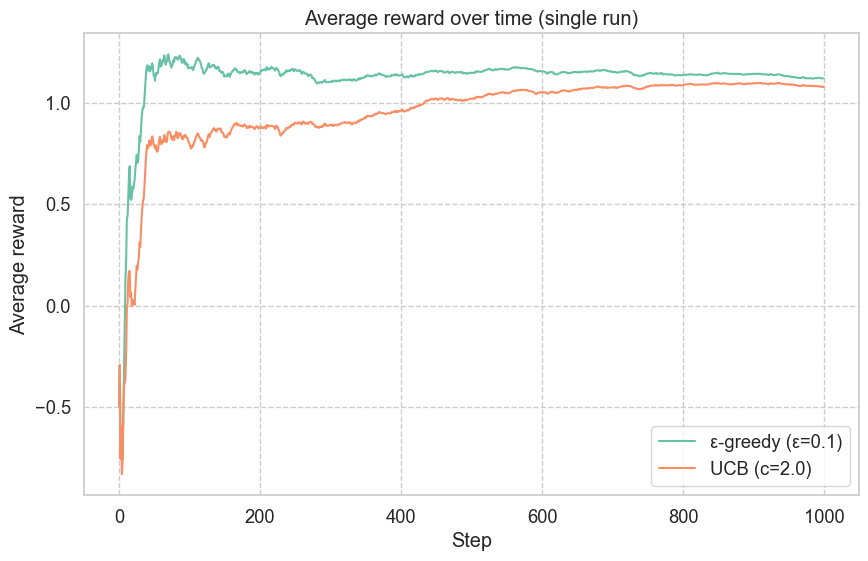

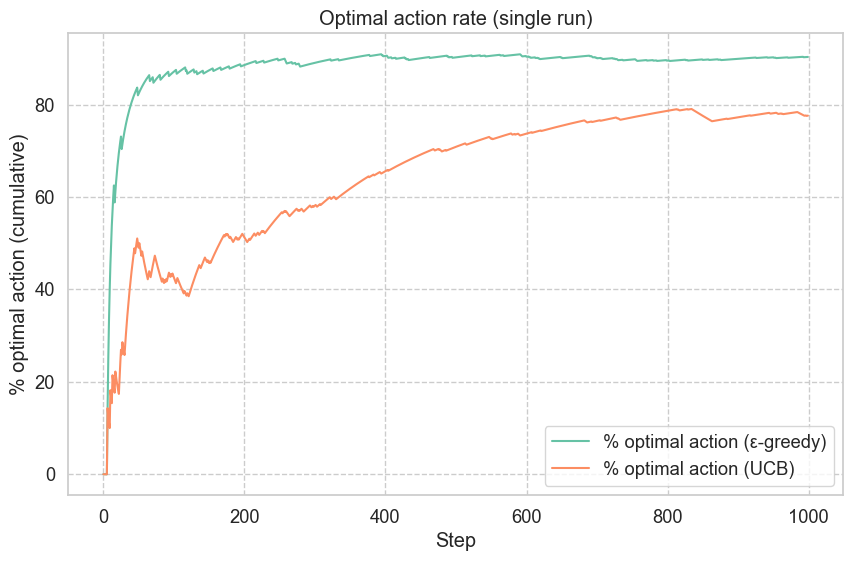

In [3]:
# Single-run visualization (noisy but illustrative)
steps = 1000

# Simulate one run of each policy
r_eps, opt_eps, means, Qe = run_eps_greedy(steps=steps, eps=0.1, seed=0)
r_ucb, opt_ucb, *_ = run_ucb(steps=steps, c=2.0, seed=0)

# Cumulative average reward over time
avg_r_eps = np.cumsum(r_eps) / np.arange(1, steps + 1)
avg_r_ucb = np.cumsum(r_ucb) / np.arange(1, steps + 1)

plt.figure()
plt.plot(avg_r_eps, label="ε-greedy (ε=0.1)")
plt.plot(avg_r_ucb, label="UCB (c=2.0)")
plt.xlabel("Step")
plt.ylabel("Average reward")
plt.title("Average reward over time (single run)")
plt.legend()
plt.show()

# Cumulative percentage of optimal actions selected
pct_opt_eps = 100 * np.cumsum(opt_eps) / np.arange(1, steps + 1)
pct_opt_ucb = 100 * np.cumsum(opt_ucb) / np.arange(1, steps + 1)

plt.figure()
plt.plot(pct_opt_eps, label="% optimal action (ε-greedy)")
plt.plot(pct_opt_ucb, label="% optimal action (UCB)")
plt.xlabel("Step")
plt.ylabel("% optimal action (cumulative)")
plt.title("Optimal action rate (single run)")
plt.legend()
plt.show()


### Why average results over multiple runs?

Bandit learning is inherently stochastic: rewards are noisy, and even the actions can be random when exploration is used. A single trajectory therefore provides a high‑variance view of performance and can be misleading—what looks like a better policy may simply reflect a lucky (or unlucky) seed. 

To address this randomness, we can run the same policy with independent random seeds and averaging the per‑step outcomes. In doing so, variance is reduced and the underlying expected learning curve becomes visible, making comparisons between algorithms fairer. 

When reading the averaged plots, focus on early learning speed, asymptotic average reward, and the fraction of optimal actions; averaging also makes sensitivity to hyperparameters such as $\varepsilon$ and $c$ easier to see. If desired, one can complement the mean curves with uncertainty quantification—standard‑error bands or bootstrap confidence intervals—to show how much variability remains across runs. Below, each policy is executed many times with different seeds and the per‑step averages are plotted.


Evaluating eps_greedy:   0%|          | 0/300 [00:00<?, ?run/s]

Evaluating ucb:   0%|          | 0/300 [00:00<?, ?run/s]

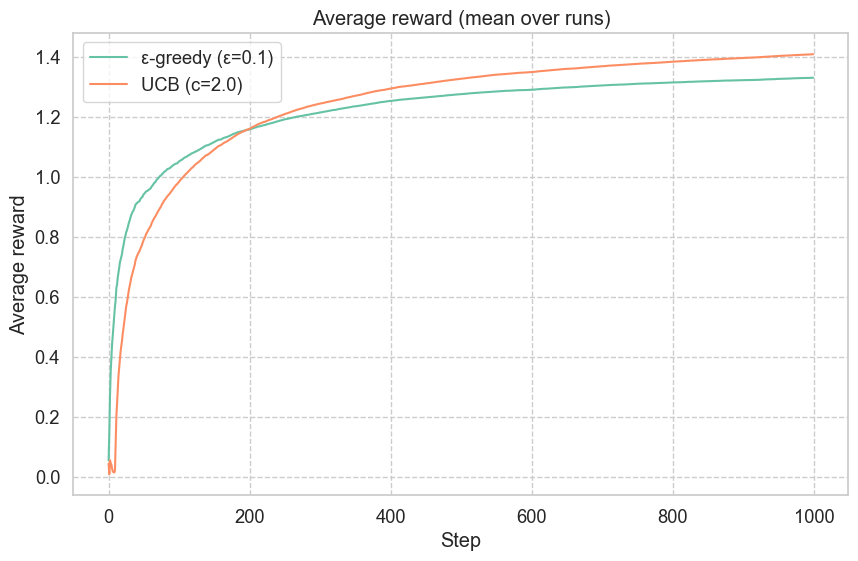

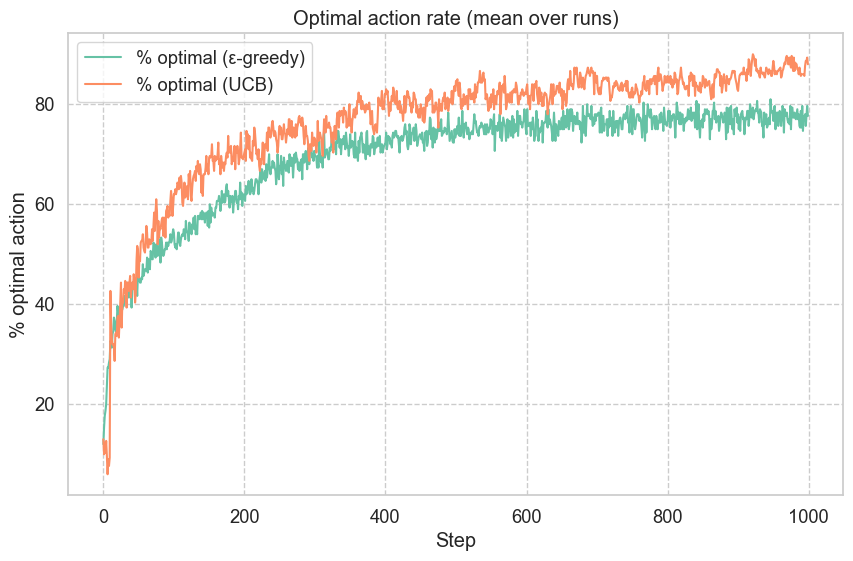

In [4]:
# Multi-run averages for reliability

from typing import Callable
from numpy.typing import NDArray
from tqdm.auto import tqdm

def evaluate(
    policy_fn: Callable[..., tuple[NDArray[np.float64], NDArray[np.int64], NDArray[np.float64], NDArray[np.float64]]],
    runs: int = 500,
    steps: int = 1000,
    **kwargs,
) -> tuple[NDArray[np.float64], NDArray[np.float64]]:
    """Computes mean learning curves by averaging multiple runs.

    For each run, it re-instantiates the environment (via unique seeds)
    and executes the provided policy function.

    Args:
      policy_fn: Function that runs a policy and returns ``(rewards, optimal, true_means, Q)``.
      runs: Number of independent runs to average over.
      steps: Number of steps per run.
      **kwargs: Additional keyword arguments forwarded to ``policy_fn``.

    Returns:
      avg_rewards: Per-step average reward across runs (length ``steps``).
      avg_optimal: Per-step fraction of optimal actions across runs (length ``steps``).
    """
    rewards = np.zeros((runs, steps))
    optimal = np.zeros((runs, steps), dtype=float)
    policy_name = policy_fn.__name__.replace("run_", "")
    iterator = tqdm(range(runs), desc=f"Evaluating {policy_name}", unit="run")
    for i in iterator:
        r, o, *_ = policy_fn(steps=steps, seed=i, **kwargs)
        rewards[i] = r
        optimal[i] = o
    return rewards.mean(0), optimal.mean(0)

steps = 1000

# Evaluate both policies across many runs for smoother curves
avg_r_eps, avg_o_eps = evaluate(run_eps_greedy, runs=300, steps=steps, eps=0.1)
avg_r_ucb, avg_o_ucb = evaluate(run_ucb, runs=300, steps=steps, c=2.0)

# Average cumulative reward over time (mean over runs)
mean_avg_r_eps = np.cumsum(avg_r_eps) / np.arange(1, steps + 1)
mean_avg_r_ucb = np.cumsum(avg_r_ucb) / np.arange(1, steps + 1)

plt.figure()
plt.plot(mean_avg_r_eps, label="ε-greedy (ε=0.1)")
plt.plot(mean_avg_r_ucb, label="UCB (c=2.0)")
plt.xlabel("Step")
plt.ylabel("Average reward")
plt.title("Average reward (mean over runs)")
plt.legend()
plt.show()

# Mean optimal action rate (percentage)
plt.figure()
plt.plot(100 * avg_o_eps, label="% optimal (ε-greedy)")
plt.plot(100 * avg_o_ucb, label="% optimal (UCB)")
plt.xlabel("Step")
plt.ylabel("% optimal action")
plt.title("Optimal action rate (mean over runs)")
plt.legend()
plt.show()
